<a href="https://colab.research.google.com/github/cesarniyo/NLP-TWITTER-SENTIMENT-ANALYSIS/blob/master/ULMFiT_for_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NLP APPLICATION IN TWITTER SENTIMENT ANALYSIS ( **Using Deep Learning / ULMFiT framework**)






This project is organized into following parts:

-  Introduction
-  Exploration data analysis
-  Data visualization
-  Data Preprocessing and Preparation
-  Fine-tune the pre-trained language model on our  dataset
-  Building the Text Classifier model (based on the above  fine-tuned language model)
-  Evaluating the Model
-  Testing the built Model
-  Conclusion



## Introduction



This project is about the application of Natural Language Processing in Sentiment analysis (text classification ) . Our dataset is made of  data collected from customer's Twitter  comments to the US Airlines expressing their satisfaction, non satisfaction or neutrality on offered services.  We will visualize the Reviews that people have put forward, thereafter  based on those comments we will be building a Prediction Model using the ULMFit method of ML fastai library.

In this project we consider using Deep Learning algorithms(very useful for huge and unstructured data) for the best known results of them in different fields of Machine learning, however one of the biggest challenges in deep learning is  the massive data requirements for training the models. 
Therefore, instead of  training a deep learning model from scratch on a small amounts of training data we got, we  will use the pre-trained model for NLP which can be fine-tuned and used on different text datasets, this  concept is called transfer learning and we will use the ULMFit framework to archive that task.
Also we will use Google Colab to avoid another DL obstacle which is the  high cost of GPU needed to run advanced deep learning algorithms.

The built  model can be used for business purposes  to improve the quality of  services.

## Exploration data analysis

In [76]:
#Let's install PyTorch and fastai libraries first. Repeat this step every time you restart this notebook in colab.
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install fastai

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html


In [77]:
# Also let us import needed libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt

import io
import os

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
color = sns.color_palette()
import plotly.tools as tls
from plotly.offline import download_plotlyjs, init_notebook_mode,plot,iplot

import warnings
warnings.filterwarnings('ignore')
from functools import partial

import fastai
from fastai import *
from fastai.text import * 



In [0]:
# Now let's load in the data
path = "/content/Tweets.csv"
df = pd.read_csv(path)


In [79]:
# At this point we can have a look on the dataset structure
df.head()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [80]:
# Checking on the shape of the dataset
df.shape

(14640, 15)

In [81]:
# Following are the dataset columns names: 
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [82]:
# Let us now see the data type in each column
df.dtypes

tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
dtype: object

In [83]:
#Go ahead and  have a look on the target distributions bellow:
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

## Data visualization

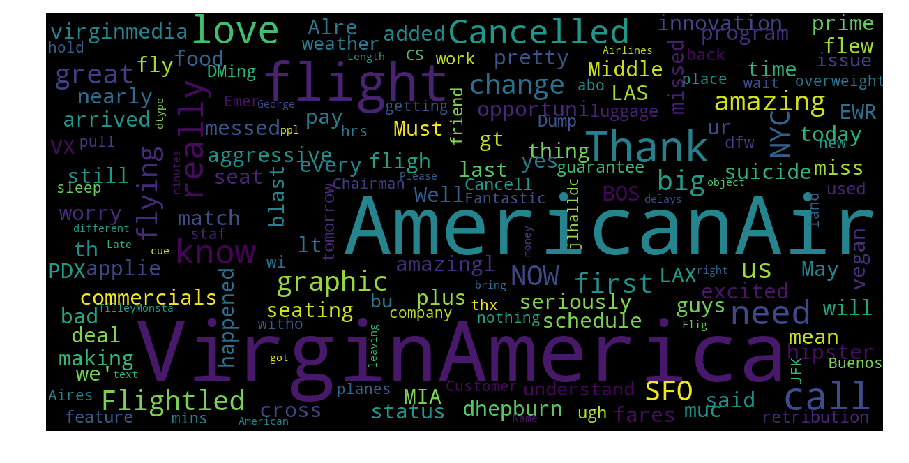

In [84]:
#Words that people have used the most in their reviews are desplayed below:

from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 
).generate(str(data))
    

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(df['text'])

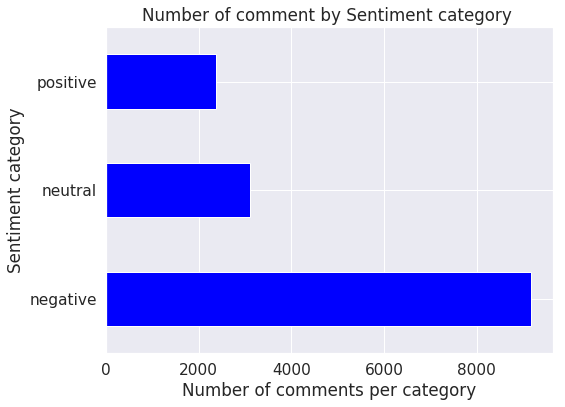

In [85]:
#Number of comment  by sentiment categories : Note that a big number of comments comes from unsatisfied customers
def plot_bars(df, cols):
    for col in cols:
        fig = plt.figure(figsize=(8,6)) # define plot area
        ax = fig.gca() # define axis    
        counts = df[col].value_counts()# find the counts for each unique category
        counts.plot.barh(ax = ax, color = 'blue') # Use the plot.bar method on the counts data frame
        ax.set_title('Number of comment by Sentiment category ') # Give the plot a main title
        ax.set_xlabel('Number of comments per category') # Set text for the x axis
        ax.set_ylabel('Sentiment category')# Set text for y axis
        #plt.tight_layout()
        plt.show()

plot_cols = ['airline_sentiment']
plot_bars(df, plot_cols)

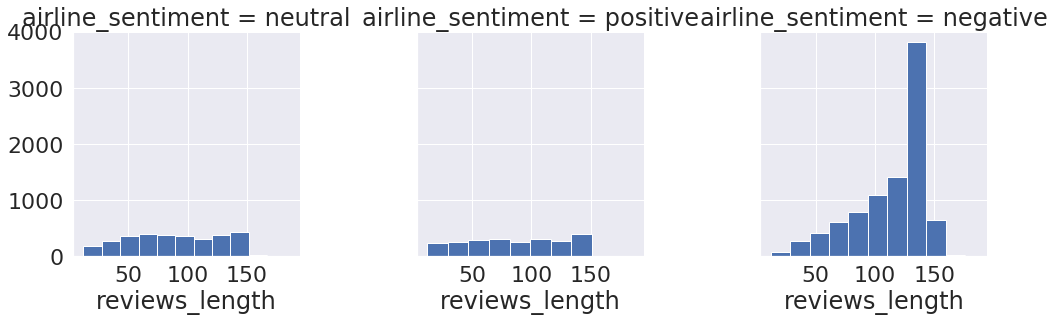

In [86]:
#Now let's have a look on what the length of the comment tells about the feeling of customers :
#Notice: negative review tend to be longer than other categories (most of negative reviewsnegative review are within 100-150 review-length)


df['reviews_length']=df['text'].apply(len)
sns.set(font_scale=2.0)

g = sns.FacetGrid(df,col='airline_sentiment',size=5)
g.map(plt.hist,'reviews_length')
plt.tight_layout()


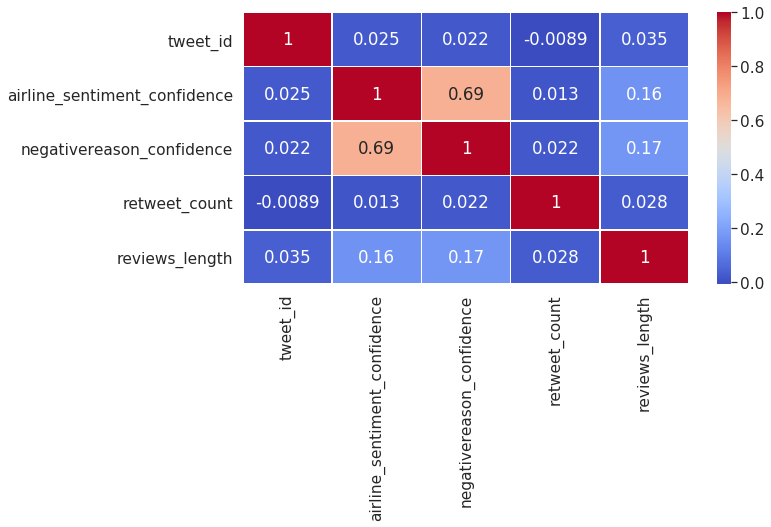

In [87]:

#There is a kind of correlation between  'airline_sentiment_confidence' and 'negativereason_confidence' 
#while no significant correlation among other categories as displayed bellow


sns.set(font_scale=1.4)
plt.figure(figsize = (10,5))
sns.heatmap(df.corr(),cmap='coolwarm',annot=True,linewidths=.5)


## Data  Preprocessing and Preparation

In [0]:
# Recoding  targets from string to integers for Machine learnig training process purposes

df.loc[df["airline_sentiment"]=='neutral',"airline_sentiment",]=0
df.loc[df["airline_sentiment"]=='positive',"airline_sentiment",]=1
df.loc[df["airline_sentiment"]=='negative',"airline_sentiment",]=2



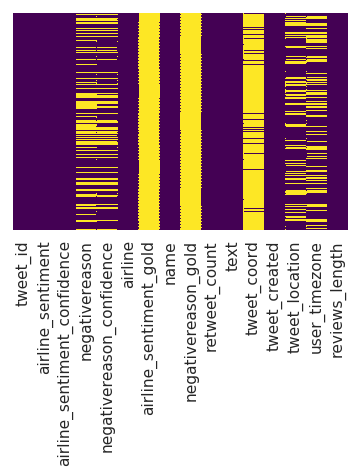

In [89]:
#Dealing with missing value/ Columns with missing values are shown below in yellow
import seaborn as sns
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [0]:
#dropping columns with missing values
df.drop(['tweet_id', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count','tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],axis=1,inplace=True) 

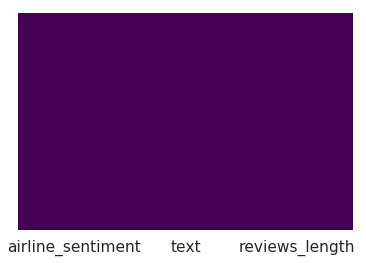

In [91]:
#double checking on the rest of data after cleaning
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [0]:
#cleaning our text by retaining only alphabets and removing everything else.
df['text'] = df['text'].str.replace("[^a-zA-Z]", " ")

In [93]:
#We will now get rid of the stopwords from our text data
# First step let's download stopwords 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
stop_words = stopwords.words('english')
                             

# lowering every word first    
lowered_doc = df['text'].apply(lambda x: x.lower())

# Next we will do text tokenization to have all of words individually separated
tokenized_doc = lowered_doc.apply(lambda x: x.split())
#tokenized_doc = df['text'].apply(lambda x: x.split())

# then remove stop-words 
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words]) 


# de-tokenization 
detokenized_doc = [] 
for i in range(len(df)): 
    t = ' '.join(tokenized_doc[i]) 
    detokenized_doc.append(t) 
df['text'] = detokenized_doc                             
                             

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn, df_val = train_test_split(df, stratify = df['airline_sentiment'], test_size = 0.3, random_state = 12)

In [95]:
df_trn.shape, df_val.shape

((10248, 3), (4392, 3))

##  Fine-tune the pre-trained language model on our  dataset


The idea behind the ULMFit framework in our project is to use transfer learning for  classification task. Our language model is initialized with the weights of a model pretrained on a larger corpus, Wikitext 103(not randomly initialized as usual ML does it). However, the vocabulary of the two datasets are slightly different, so when loading the weights, we have to remember to put the embedding weights at the right place, and we randomly initiliaze the embeddings for words in the TWITTER dataset vocabulary that weren't in the wikitext-103 vocabulary of our pretrained model.


In [0]:
# Language model data acquisition
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")
#data_lm.show_batch()

In [0]:
# Download and fine-tune the pre-trained language model on new dataset/ 
#The new language model is trained to guess what the next word in the sentence is in our twitter world!

learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.8) 


In [98]:
#The Learner object we get is frozen by default, which means we only train the embeddings at first (since some of them are random).
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,6.841968,5.692119,0.142776,00:10


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


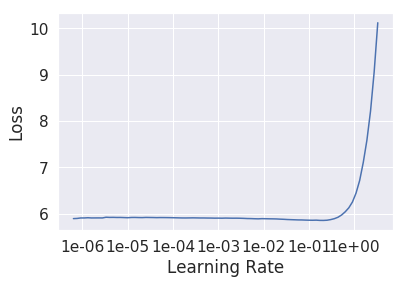

In [99]:
#Displaying learning rate finder result
learn.lr_find()
learn.recorder.plot()

In [100]:
#Then we unfreeze the model and fine-tune the whole 
learn.unfreeze()
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,5.762928,5.382946,0.175162,00:12
1,5.490155,5.211452,0.185958,00:12
2,5.186690,5.177732,0.186993,00:12
3,4.809137,5.263977,0.186729,00:12
4,4.435000,5.386525,0.184091,00:12


In [0]:
#Once done, we just save the encoder of the model,we will use it building the classifier.
learn.save_encoder('ft_enc')

##  Building the Text Classifier model

 We don't load the pretrained model,  instead, we to load our fine-tuned encoder from the previous section.The classifier needs some dropout, so we pass drop_mult=0.8 to multiply all the dropouts by this amount.

In [0]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=100)

In [0]:
learn = text_classifier_learner(data_clas,AWD_LSTM, drop_mult=0.8)
learn.load_encoder('ft_enc') #loading the saved encoder and  use it to build our classifier.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


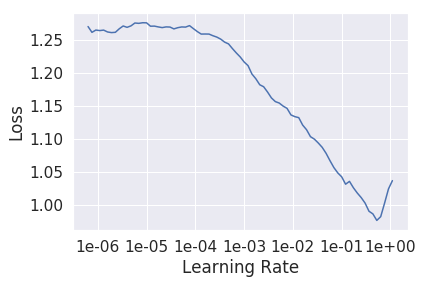

In [104]:
learn.lr_find()
learn.recorder.plot()

Then we train the model using gradual unfreezing (partially training the model from everything but the classification head frozen to the whole model trianing by unfreezing one layer at a time) and differential learning rate (deeper layer gets a lower learning rate).

In [105]:
lr = 1e-1
learn.fit_one_cycle(1, lr, moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,0.745650,0.592338,0.755692,00:17


In [106]:

learn.freeze_to(-2)
lr /= 2
learn.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.667957,0.542815,0.776867,00:18


In [107]:
learn.freeze_to(-3)
lr /= 2
learn.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.625515,0.535969,0.773452,00:23


In [108]:
#unfreezing the whole model
learn.unfreeze()
lr /= 5
learn.fit_one_cycle(5, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.548531,0.520507,0.793260,00:26
1,0.509613,0.512075,0.795993,00:27
2,0.487128,0.506395,0.800774,00:26
3,0.445042,0.511323,0.802596,00:26
4,0.409637,0.515574,0.801457,00:26


In [0]:
#saving the NEW MODEL
learn.save('clas_mod')

## Evaluating the Classifier Model

In [110]:
# get predictions
preds, targets = learn.get_preds()

predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)

col_0,0,1,2
row_0,,,
0,511,73,172
1,99,521,93
2,320,115,2488


In [111]:
# Model Accuracy 

pred,label= learn.get_preds(ordered=True)
accuracy(pred, label)

tensor(0.8015)

## Testing the Built Model

No handles with labels found to put in legend.


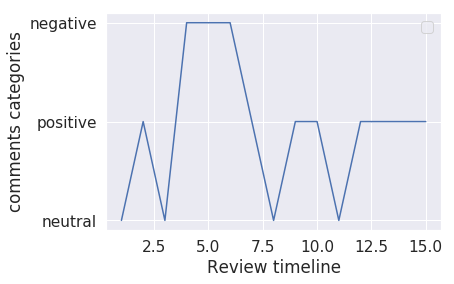

In [112]:
#Testing the model
def textclassification(text):
  
    mod=learn.load('clas_mod')  
    pred=mod.predict(text)
    
    if (np.argmax(pred[2]))==0:
      return 'neutral'
    
    elif (np.argmax(pred[2]))==1:
      return 'positive'
    
    elif (np.argmax(pred[2]))==2:
      return 'negative' 
    
    

    
#function to display the customer feelings timeline
def customer_feelings_timeline(comments):
    X=[]
    y=[]
    x=0
    for comment in comments:
        y.append(textclassification(comment))
        x+=1
        X.append(x)

    fig=()
    plt.plot(X, y)
    plt.legend()
    plt.xlabel('Review timeline')
    plt.ylabel('comments categories')
    plt.show()

    
    
comments=df['text'][:15]#testing the model with first 15 review from customers
customer_feelings_timeline(comments)


## Conclusion



In this challenge, several data mining techniques including; Exploration data analysis, Data visualization,Data preprocessing and preparation
were combined with both deep learning and transfer learning techniques   to building a  Machine Learning Model. The models perfomences on dataset  come up to 80.0%. The ULMFit helped to reduce training time also the requirement for massive data for training the best model ready to deploy for the business.




'''

## Project solution Presented by:

Cesar Niyomugabo